Essentials imports.

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random as rn
from PIL import Image
from skimage import feature
from sklearn.preprocessing import LabelEncoder

Taking a glance at the data.

In [243]:
labels = pd.read_csv("datasets/bee_data.csv", index_col=0)

labels.head()

,date,time,location,zip code,subspecies,health,pollen_carrying,caste
file,,,,,,,,
041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


Save the subspecies labels.

In [244]:
subspecies = labels.subspecies.unique().tolist()

Remove file as the index using reset_index() method.

In [245]:
labels = labels.reset_index()

Making the no. of training data equally distributed for each subspecies.

In [246]:
cols = ['subspecies', 'file']
labels = labels[cols]
subspecies_count = labels.groupby("subspecies").count()

In [247]:
subspecies_count.reset_index(inplace=True)

In [248]:
subspecies_count

,subspecies,file
0,-1,428
1,1 Mixed local stock 2,472
2,Carniolan honey bee,501
3,Italian honey bee,3008
4,Russian honey bee,527
5,VSH Italian honey bee,199
6,Western honey bee,37


In [249]:
drop_rows = subspecies_count[subspecies_count.file < 400].subspecies.tolist()
print(drop_rows)

['VSH Italian honey bee', 'Western honey bee']


Drop the subclasses with less then 400 samples.

In [250]:
for subspecies in drop_rows:
    labels.drop(labels[labels.subspecies == subspecies].index, inplace=True)

In [251]:
labels.groupby("subspecies").count().reset_index()

,subspecies,file
0,-1,428
1,1 Mixed local stock 2,472
2,Carniolan honey bee,501
3,Italian honey bee,3008
4,Russian honey bee,527


Decrease the no. of instance for "Italian honey bee" to 500.

In [252]:
labels_IHB = labels[labels.subspecies == 'Italian honey bee']
labels.drop(labels[labels.subspecies == 'Italian honey bee'].index, inplace=True)

In [253]:
labels = labels.append(labels_IHB[:500])

In [254]:
labels.groupby("subspecies").count().reset_index()

,subspecies,file
0,-1,428
1,1 Mixed local stock 2,472
2,Carniolan honey bee,501
3,Italian honey bee,500
4,Russian honey bee,527


Randomize the data.

In [255]:
labels = labels.sample(frac=1).reset_index(drop=True)

Create a function to display image refrence to its index and return the subspecies of the bee nad the file name.

In [256]:
def show_image(index):
    """
    Displays an image from the dataset with respect to the given index and returns the subspecies|.
    """
    file_name = labels[labels.index==index].file.values[0]
    subspecies = labels[labels.index==index].subspecies.values[0]
    root="datasets/bee_imgs/"
    img_path = os.path.join(root, file_name)
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.show()
    return file_name, subspecies
    

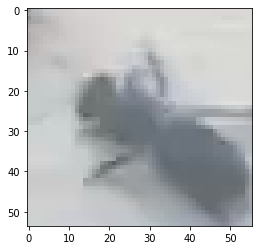

('046_063.png', 'Carniolan honey bee')

In [257]:
show_image(0)

Generate the hog features.

In [258]:
def hog_data_extractor(img_name):
    root="datasets/bee_imgs/"
    img_path = os.path.join(root, img_name)
    img_data = cv2.imread(img_path)
    img_data = cv2.resize(img_data, (150, 150))
    hog_data = feature.hog(img_data)/255.0
    return hog_data

In [259]:
hog_data_extractor("041_073.png")

array([1.03128687e-03, 3.53268733e-04, 0.00000000e+00, ...,
       4.36513914e-05, 4.01787839e-05, 2.50650593e-04])

Save file_name and subspecies to array.

In [260]:

file_name_all = labels.file.values
subspecies_all = labels.subspecies.values

In [272]:
print(subspecies_all)

['Carniolan honey bee' '-1' '1 Mixed local stock 2' ...
 'Carniolan honey bee' '-1' 'Russian honey bee']


Store the hog features in to X_train and X_test.

In [262]:
X_train = []
X_test = []
label_train = []
label_test = []

train_percent = 0.8
data_length = len(file_name_all)
train_index = int(data_length*train_percent)

In [263]:

for i in range(train_index):
    try:
        hog_data = hog_data_extractor(file_name_all[i])
        X_train.append(hog_data)
        label_train.append(subspecies_all[i])
    except:
        print(file_name_all[i], subspecies_all[i])
        print("Error")

In [264]:
for i in range(train_index, data_length):
    try:
        hog_data = hog_data_extractor(file_name_all[i])
        X_test.append(hog_data)
        label_test.append(subspecies_all[i])
    except:
        print(file_name_all[i], subspecies_all[i])
        print("Error")

Use label encoder to encode the subspecies.

In [265]:
le = LabelEncoder()
y_train = le.fit_transform(label_train)
y_test = le.fit_transform(label_test)

Create a Linear SVM classifier and train it.

In [308]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC


In [312]:
svc = SVC(C=1.2, kernel='rbf', random_state=0, tol=1e-5)
svc.fit(X_train, y_train)
svc_score = svc.score(X_test, y_test)
print("svc_score: ", svc_score)

Score and Cross Value result of the model.

In [318]:
# filter all the warnings
import warnings
warnings.filterwarnings("ignore")

# 10-fold cross validation
kfold = KFold(n_splits=10, random_state=9, shuffle=True)
cv_results = cross_val_score(svc, X_train, y_train, cv=kfold, scoring='accuracy')
print(cv_results)

Score 0.7942386831275721
[0.78461538 0.77948718 0.79896907 0.77835052 0.74226804 0.78865979
 0.77835052 0.78865979 0.76804124 0.79381443]


In [317]:
print(cv_results.mean(), cv_results.std())

0.6045096484271741 0.02910331006039511


Classification Reoport:

In [314]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      0.54      0.59        97
           1       0.93      0.89      0.91       104
           2       0.97      0.94      0.95        93
           3       0.65      0.71      0.68        96
           4       0.77      0.90      0.83        96

    accuracy                           0.79       486
   macro avg       0.79      0.79      0.79       486
weighted avg       0.79      0.79      0.79       486



In [315]:
def scene_predict(img_name):
    root="datasets/bee_imgs/"
    img_path = os.path.join(root, img_name)
    image = cv2.imread(img_path)
    ip_image = Image.open(img_path)
    image = cv2.resize(image, (150, 150))
    prd_image_data = hog_data_extractor(img_name)
    subspecies_predict = svc.predict(prd_image_data.reshape(1, -1))[0]
    fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
    ax[0].imshow(ip_image)
    ax[0].set_title("Input Image:" + labels.subspecies[labels.file == img_name].values[0], color='red')
    
    ax[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Predicted Image:" + subspecies_all[subspecies_predict], color='green')

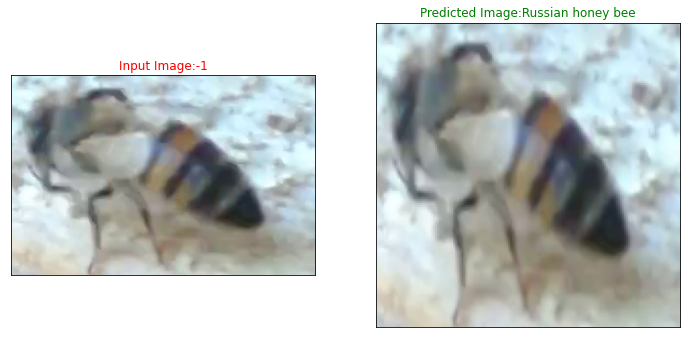

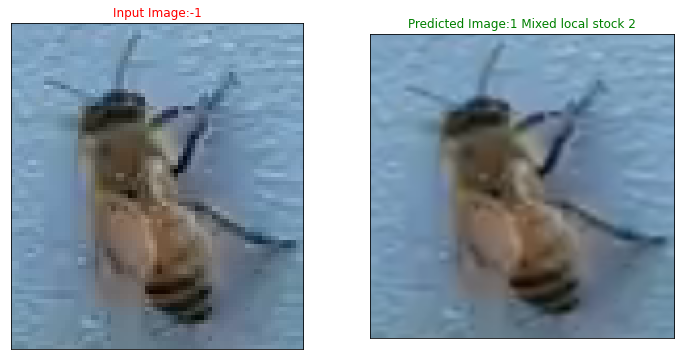

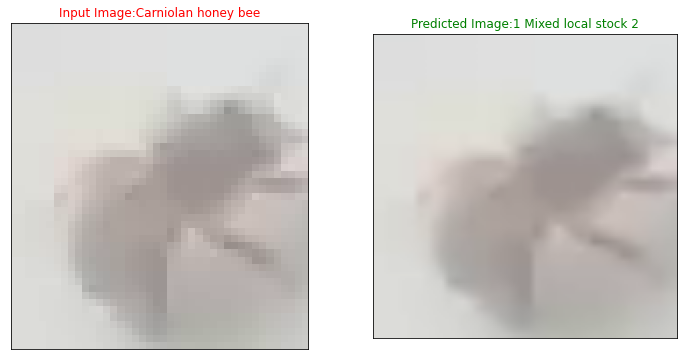

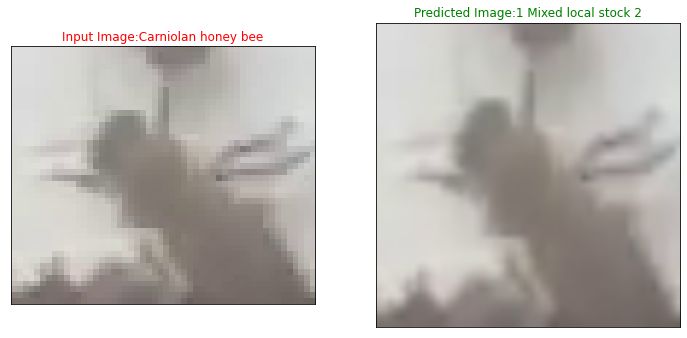

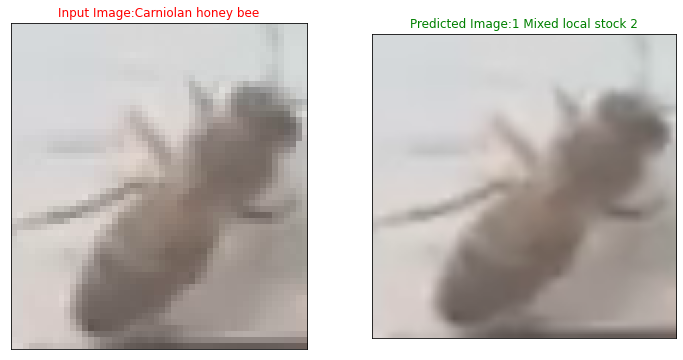

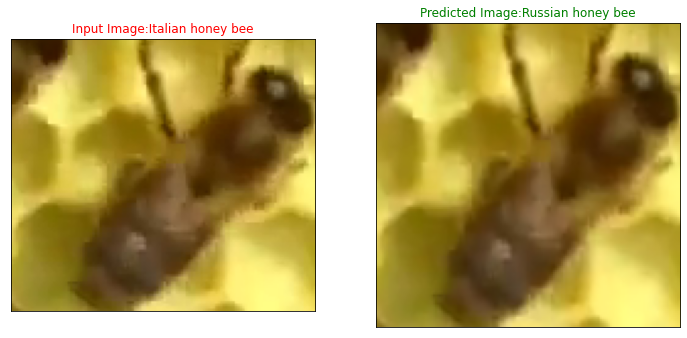

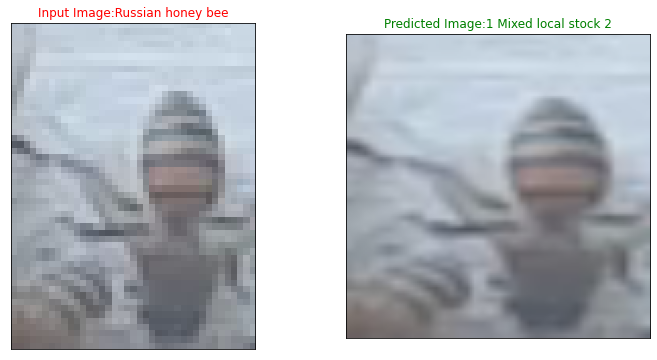

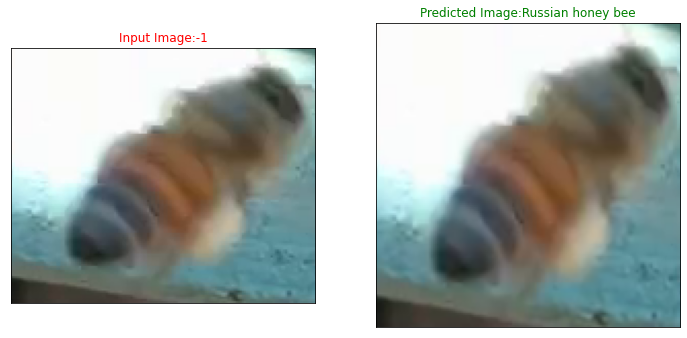

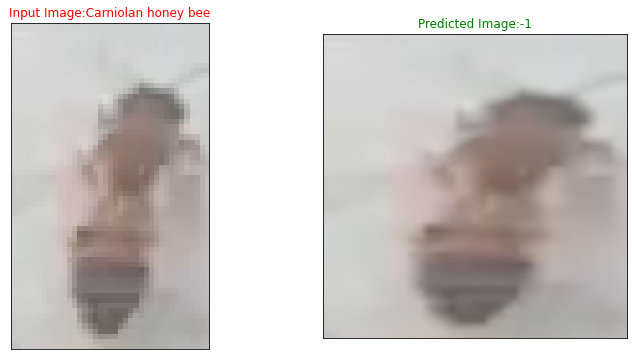

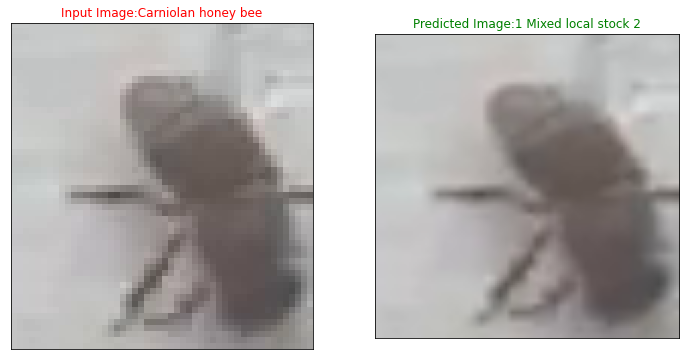

In [316]:
ip_img_files = labels.file.values.tolist()
rnd = rn.randint(0, len(ip_img_files)-1)
scene_predicted = [scene_predict(img_name) for img_name in ip_img_files[rnd:rnd+10]]